In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)

In [2]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import RocCurveDisplay
roc_curve_est = RocCurveDisplay.from_estimator 
roc_curve_pred = RocCurveDisplay.from_predictions 

In [3]:
# Load the data

Default = load_data('Default')
Default

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


In [4]:
# Do some preliminary feature engineering prior to any modeling
X=Default[['balance','income','student']]

X.loc[X['student']=="Yes", 'student_yes'] = 1
X.loc[X['student']=="No", 'student_yes'] = 0
X.drop(columns='student', axis=1, inplace=True)
X

,balance,income,student_yes
0,729.526495,44361.625074,0.0
1,817.180407,12106.134700,1.0
2,1073.549164,31767.138947,0.0
3,529.250605,35704.493935,0.0
4,785.655883,38463.495879,0.0
...,...,...,...
9995,711.555020,52992.378914,0.0
9996,757.962918,19660.721768,0.0
9997,845.411989,58636.156984,0.0
9998,1569.009053,36669.112365,0.0


In [5]:
# Create the target

y = Default.default == 'Yes'

In [46]:
# Create train and test split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.25,
                                                    shuffle=True) 
Train = pd.merge_ordered(X_train,y_train,left_on=X_train.index,right_on=y_train.index).drop(columns=['key_0'])
Test = pd.merge_ordered(X_test,y_test,left_on=X_test.index,right_on=y_test.index).drop(columns=['key_0'])

## $k$-Nearest Neighbors

In [47]:
# kNN requires an array as input, so we'll make copies of the train and test X's

X_train_knn, X_test_knn = [np.asarray(X) for X in [X_train, X_test]]

In [48]:
# First we'll try using only the nearest neighbor (k=1)

knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train_knn, y_train)
knn1_test = knn1.predict(X_test_knn)

In [ ]:
confusion_table(knn1_test, y_test)

3984    False
1769    False
514     False
4223    False
2804    False
        ...  
7912    False
9652    False
1391    False
2396    False
6919    False
Name: default, Length: 2500, dtype: bool

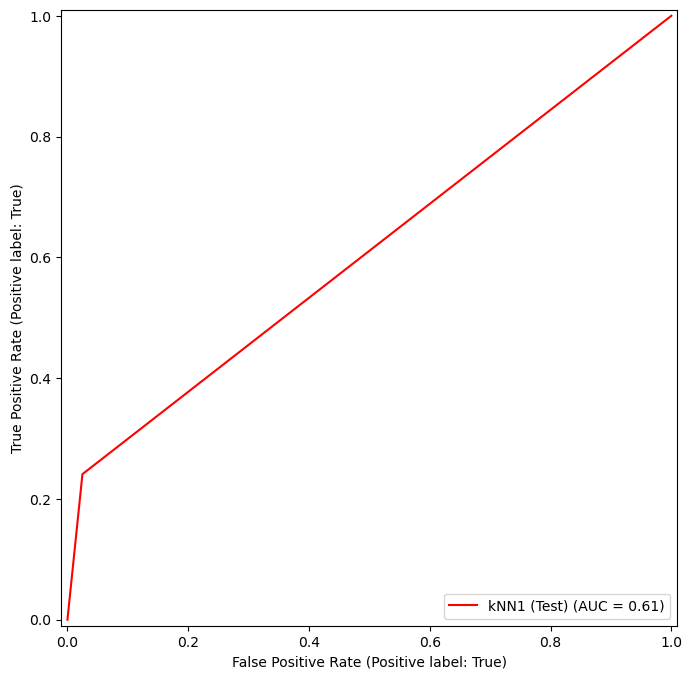

In [10]:
# We'll create an ROC plot and keep adding curves from new models to it

fig, ax = subplots(figsize=(8,8))
roc_curve_est(knn1,
              X_test_knn,
              y_test,
              name='kNN1 (Test)',
              color='r',
              ax=ax);

In [11]:
# Now we'll try 10 nearest neighbors

knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train_knn, y_train)
knn10_test = knn10.predict(X_test_knn)

In [12]:
confusion_table(knn10_test, y_test)

Truth,False,True
Predicted,,
False,2414,79
True,3,4


In [13]:
# Wait, only 7 records were marked true?

knn10_test_prob = knn10.predict_proba(X_test_knn)[:,1]
knn10_test_prob

array([0.1, 0. , 0. , ..., 0.1, 0. , 0. ])

In [14]:
# What if we change the threshold? 
# Try to get the number of false positives and false negatives to be about the same

knn10_test_pred = np.array([True]*len(y_test))
knn10_test_pred[knn10_test_prob<=0.2] = False

In [15]:
confusion_table(knn10_test_pred, y_test)

Truth,False,True
Predicted,,
False,2369,57
True,48,26


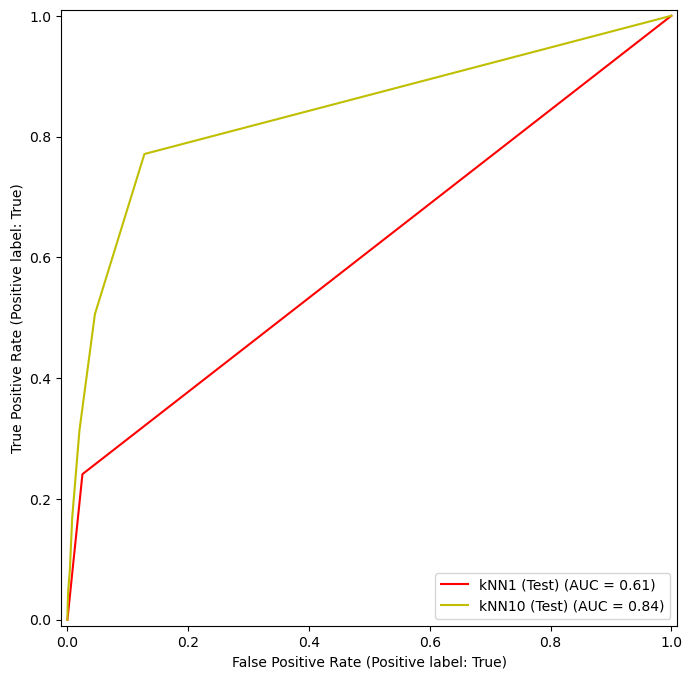

In [16]:
roc_curve_est(knn10,
              X_test_knn,
              y_test,
              name='kNN10 (Test)',
              color='y',
              ax=ax);
fig

In [17]:
# How about 20 nearest neighbors?

knn20 = KNeighborsClassifier(n_neighbors=20)
knn20.fit(X_train_knn, y_train)
knn20_test = knn20.predict(X_test_knn)

In [18]:
confusion_table(knn20_test, y_test)

Truth,False,True
Predicted,,
False,2417,82
True,0,1


In [19]:
knn20_test_prob = knn20.predict_proba(X_test_knn)[:,1]

knn20_test_pred = np.array([True]*len(y_test))
knn20_test_pred[knn20_test_prob<=0.15] = False

confusion_table(knn20_test_pred, y_test)

Truth,False,True
Predicted,,
False,2351,56
True,66,27


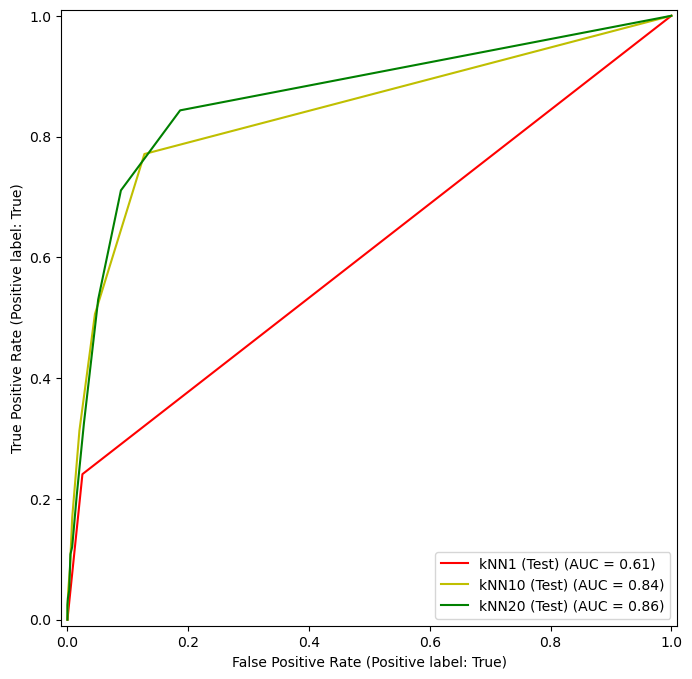

In [20]:
# How does the ROC curve look?

roc_curve_est(knn20,
              X_test_knn,
              y_test,
              name='kNN20 (Test)',
              color='g',
              ax=ax);
fig

In [21]:
# How about 100 nearest neighbors?

knn100 = KNeighborsClassifier(n_neighbors=100)
knn100.fit(X_train_knn, y_train)
knn100_test = knn100.predict(X_test_knn)

In [22]:
confusion_table(knn100_test, y_test)

Truth,False,True
Predicted,,
False,2417,83
True,0,0


In [23]:
knn100_test_prob = knn100.predict_proba(X_test_knn)[:,1]

knn100_test_pred = np.array([True]*len(y_test))
knn100_test_pred[knn100_test_prob<=0.09] = False

confusion_table(knn100_test_pred, y_test)

Truth,False,True
Predicted,,
False,2352,58
True,65,25


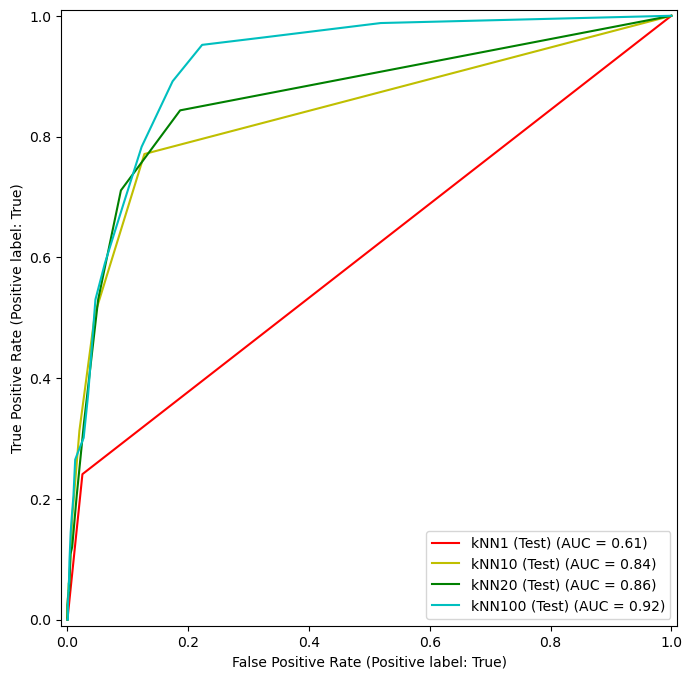

In [24]:
roc_curve_est(knn100,
              X_test_knn,
              y_test,
              name='kNN100 (Test)',
              color='c',
              ax=ax);
fig

## Logistic Regression

In [25]:
# We'll need to add an intercept column to our X dataframes

X_train['intercept'] = np.ones(X_train.shape[0])
X_test['intercept'] = np.ones(X_test.shape[0])

In [26]:
# Run the logistic regression model

glm = sm.GLM(y_train,
             X_train,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
balance,0.005800,0.00000,21.439,0.000
income,0.000007,0.00001,0.715,0.475
student_yes,-0.700700,0.27600,-2.536,0.011
intercept,-11.082500,0.57800,-19.161,0.000


In [27]:
def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

In [28]:
# Get the predicted probabilities

probs_train=predict(X_train,results)
probs_test=predict(X_test,results)

In [29]:
# We'll use 0.3 as the threshold for True vs. False

predictions_train = np.array([True]*len(y_train))
predictions_train[probs_train<0.3] = False

predictions_test = np.array([True]*len(y_test))
predictions_test[probs_test<0.3] = False


In [30]:
confusion_table(predictions_test, y_test)

Truth,False,True
Predicted,,
False,2380,37
True,37,46


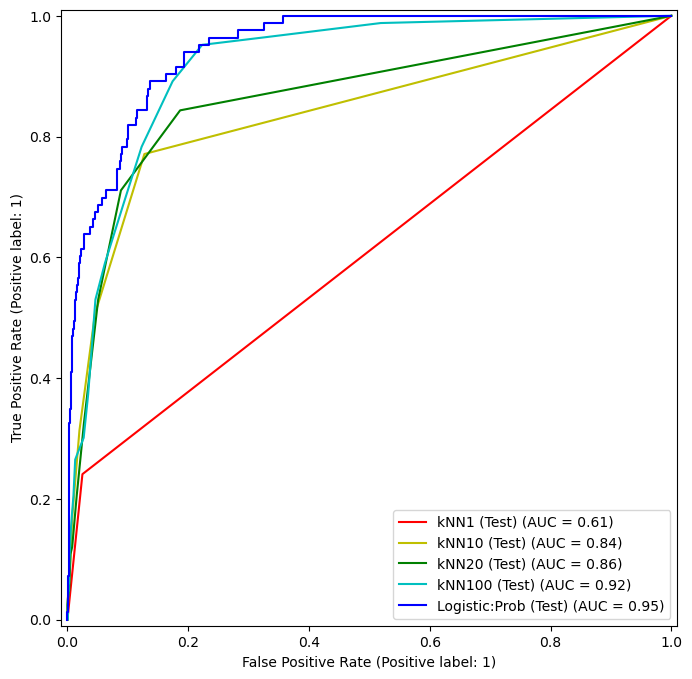

In [31]:
# Let's look at the ROC curve

roc_curve_pred(y_test,
               probs_test,
               name='Logistic:Prob (Test)',
               color='b',
               ax=ax);
fig

## LDA

In [32]:
# We'll initialize it here

lda = LDA(store_covariance=True)


In [33]:
# Let's remove the intercept column that we needed for logistic regression

X_train.drop(columns='intercept', axis=1, inplace=True)
X_test.drop(columns='intercept', axis=1, inplace=True)

In [34]:
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [35]:
# Here are the centroids for each class on the training set

lda.means_

array([[8.00704992e+02, 3.35711887e+04, 2.90206897e-01],
       [1.74465940e+03, 3.25512685e+04, 3.64000000e-01]])

In [36]:
# Here are the class names

lda.classes_

array([False,  True])

In [37]:
# Here is the order of the column names

X_train.columns

Index(['balance', 'income', 'student_yes'], dtype='object')

In [38]:
# Here are the expected probabilities of the classes

lda.priors_

array([0.96666667, 0.03333333])

In [39]:
# This is the linear combination used to decide which class to assign

lda.scalings_

array([[ 2.25089565e-03],
       [ 4.27139519e-06],
       [-1.99628557e-01]])

In [40]:
# Calculate predictions on test set (we chose 0.26 in this case)

lda_probs = lda.predict_proba(X_test)[:,1]

lda_test = np.array([True]*len(y_test))
lda_test[lda_probs<0.26] = False
lda_test

array([False, False, False, ..., False, False, False])

In [41]:
confusion_table(lda_test, y_test)

Truth,False,True
Predicted,,
False,2382,37
True,35,46


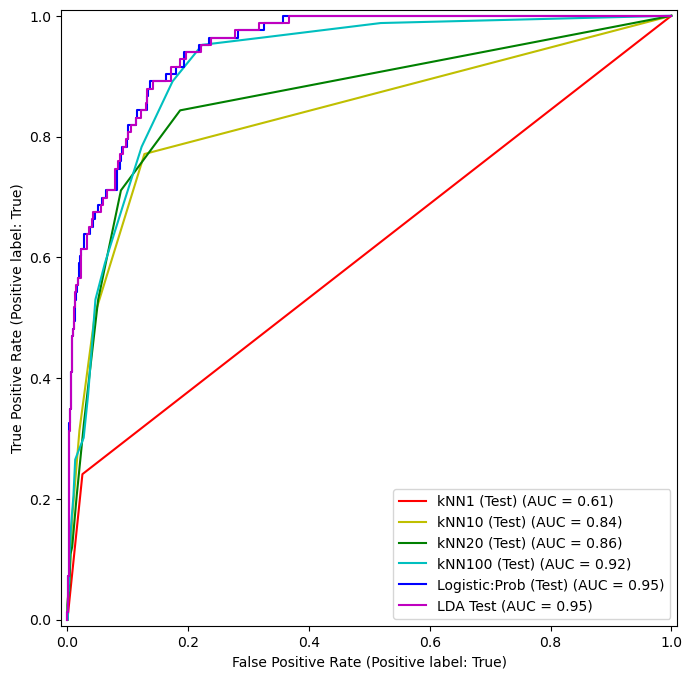

In [42]:
roc_curve = RocCurveDisplay.from_estimator 

roc_curve(lda,
          X_test,
          y_test,
          name='LDA Test',
          color='m',
          ax=ax);
fig

## Likelihood

In [43]:
# Create helper functions for computing the likelihood

def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

def like(y, y_hat):
    # create a columns of ones
    ones = np.ones(X_test.shape[0])
    # calculate the likelihood for each individual record
    like_indiv = y*(y_hat)+(ones-y)*(ones-y_hat)
    # calculate the product across records
    likelihood = np.prod(like_indiv)
    return likelihood

In [44]:
likelihood_test = like(y_test,probs_test)

In [45]:
print(likelihood_test)

1.0297741373534113e-88
